# Project 2: Covid ---> II/ Features selection

The objective of this file is to do the pre-processing and then choose which features to keep from the matrix extracted from the "I_data-selection" file, using several algorithms.
This will give us the final matrix to test the models in the "III_models-and-predictions" file.

In [2]:
# Import
%matplotlib inline

import os
import os.path as op
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import missingno as msno


from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import RidgeCV

from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import xgboost as xgb

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Our prediction will be about death or not when a patient is covid positive => Thus our y matrix will be the DSDECOD column.**

## 1. Loading the data after 'I-DataSelection"

In [3]:
# Open file
data_folder = op.join(os.getcwd(), "data", "results")
mylist = []
for chunk in pd.read_csv(op.join(data_folder, 'df_final_I-DataSelection.csv'), sep=',', low_memory=False, chunksize=5000, index_col=0):
    mylist.append(chunk)
df = pd.concat(mylist, axis=0)
df.name = 'df'
del mylist

In [4]:
# Directly removing the missing values for the predictor variable
df = df[df.DSDECOD.notna()]

In [5]:
df.shape

(578829, 103)

## 2. Premilinary features selection based on the meaning

Some columns seem to be more relevant than others for training purposes: we will delete some columns that we consider not very useful at first.

As a reminder, this is the main types of information we have:
- **DM = Demographics** --> 'AGE', 'SEX', 'CONTINENT_AF', 'CONTINENT_AS', 'CONTINENT_EU', 'CONTINENT_NA', 'CONTINENT_OC', 'CONTINENT_SA'
- **DS = Disposition** --> 'DSDECOD'
- **HO = Healthcare Encounters** --> 'HODECOD'
- **IE = Inclusion/Exclusion Criteria** --> 'IETEST_Acute_Respiratory_Infection', 'IETEST_Cough', 'IETEST_Covid_ICU', 'IETEST_Covid_admission', 'IETEST_Dyspnoea_Tachypnoea', 'IETEST_Fever', 'IETEST_Inflammatory_MultiSystem_Syndrome', 'IETEST_noCovid_ICU'
- **IN = Treatments and Interventions** --> 'INCLAS_AGENTS_ACTING_ON_THE_RENIN-ANGIOTENSIN_SYSTEM', 'INCLAS_ANTIBACTERIALS_FOR_SYSTEMIC_USE', etc..., 'INCLAS_VACCINES'
- **LB = Laboratory Results** --> 'LBTEST_ALB', 'LBTEST_ALP', etc..., 'LBTEST_WBC'
- **MB = Microbiology Specimen** --> 'MBTEST_ADENOVIRUS', 'MBTEST_BACTERIA', 'MBTEST_CORONAVIRUS', 'MBTEST_INFLUENZA', 'MBTEST_OTHER PATHOGENS', 'MBTEST_OTHER RESPIRATORY PATHOGENS', 'MBTEST_RSV
- **RP = Reproductive System Findings** --> 'RPSTRESC'
- **RS = Disease Response and Clinical Classification** --> 'RSCAT_AVPU', 'RSCAT_BLANTYRE_COMA_SCALE', 'RSCAT_CLINICAL_FRAILTY_SCORE', 'RSCAT_GCS_NINDS_VERSION', 'RSCAT_ICU_MOBILITY_SCALE', 'RSCAT_PRISM_III', 'RSCAT_RASS', 'RSCAT_SAPS_II', 'RSCAT_SAS', 'RSCAT_SOFA'
- **SA = Clinical and Adverse Events** --> 'SACAT_COMORBIDITIES', 'SACAT_COMPLICATIONS', 'SACAT_PREVIOUS_COVID-19_INFECTION'
- **SC = Subject Characteristics** --> 'SCTEST_Appropriate_Developmental_Age_Indicator', 'SCTEST_Breast_Fed_Indicator', 'SCTEST_Infant_Less_Than_One_Year_Indicator', 'SCTEST_Premature_Birth_Indicator'
- **VS = Vital Signs** --> 'VSTEST_BMI', 'VSTEST_BRTHWT', etc..., 'VSTEST_WEIGHT'

First we can keep only information from:
- DM = Demographics
- DS = Disposition
- HO = Healthcare Encounters
- IE  = Inclusion/Exclusion Criteria (only 'IETEST_Acute_Respiratory_Infection', 'IETEST_Cough', 'IETEST_Fever'
- IN  = Treatments and Interventions (only 'INCLAS_VACCINES')
- LB = Laboratory Results
- MB = Microbiology Specimen
- SA = Clinical and Adverse Events
- VS = Vital Signs

In [6]:
df.columns[40:]

Index(['INCLAS_IMMUNOSTIMULANTS', 'INCLAS_IMMUNOSUPPRESSANTS',
       'INCLAS_INSERTION_OF_TRACHEOSTOMY_TUBE', 'INCLAS_INTUBATION',
       'INCLAS_LIPID_MODIFYING_AGENTS', 'INCLAS_MUSCLE_RELAXANTS',
       'INCLAS_NONINVASIVE_POSITIVE_PRESSURE_VENTILATION',
       'INCLAS_NONINVASIVE_VENTILATION',
       'INCLAS_OTHER_RESPIRATORY_SYSTEM_PRODUCTS', 'INCLAS_OXYGEN',
       'INCLAS_PERCUTANEOUS_ENDOSCOPIC_GASTROSTOMY',
       'INCLAS_PRONE_BODY_POSITION', 'INCLAS_PSYCHOLEPTICS',
       'INCLAS_REMOVAL_OF_ENDOTRACHEAL_TUBE', 'INCLAS_RENAL_REPLACEMENT',
       'INCLAS_REPLACEMENT_AGENT', 'INCLAS_TOTAL_PARENTERAL_NUTRITION',
       'INCLAS_TRANSFUSION_OF_BLOOD_PRODUCT', 'INCLAS_VACCINES', 'LBTEST_ALT',
       'LBTEST_APTT', 'LBTEST_APTTSTND', 'LBTEST_AST', 'LBTEST_BASEEXCS',
       'LBTEST_BICARB', 'LBTEST_BILI', 'LBTEST_CD4', 'LBTEST_CK',
       'LBTEST_CREAT', 'LBTEST_CRP', 'LBTEST_FERRITIN', 'LBTEST_GLUC',
       'LBTEST_HCT', 'LBTEST_HGB', 'LBTEST_INR', 'LBTEST_K', 'LBTEST_LACTICAC',
   

In [7]:
# Keep only columns we want to continue the training

preliminary_selection = ['AGE', 'SEX', 'CONTINENT_AF', 'CONTINENT_AS', 'CONTINENT_EU', 'CONTINENT_NA', 'CONTINENT_OC', 'CONTINENT_SA',
                         'DSDECOD',
                         'HODECOD',
                         'IETEST_Acute_Respiratory_Infection', 'IETEST_Cough', 'IETEST_Fever',
                         'INCLAS_VACCINES',
                         'SACAT_COMORBIDITIES', 'SACAT_PREVIOUS_COVID-19_INFECTION'] \
                        + df.filter(regex='^LB',axis=1).columns.tolist() \
                        + df.filter(regex='^MB',axis=1).columns.tolist() \
                        + df.filter(regex='^VS',axis=1).columns.tolist()
df = df[preliminary_selection]
df.shape

(578829, 55)

In [8]:
# Verify that there is no column with too many NA (more then 99%) after I-DataSelection
df.dropna(thresh = int((100-1)*(len(df.columns)/100)), inplace=True, axis=1)
df.shape

(578829, 55)

## 3. Stratification per continent

Initially, we will build the model on patients who only come from one continent. We can then subsequently test whether the model is applicable to patients from other continents.

In [9]:
continent_list = ['CONTINENT_AF', 'CONTINENT_AS', 'CONTINENT_EU','CONTINENT_NA', 'CONTINENT_OC', 'CONTINENT_SA']

In [10]:
# Split data accordint to the continents to investigate a little bit more...

# Afrique
df_africa = df[df['CONTINENT_AF']==1]
df_africa.drop(continent_list, axis=1, inplace=True)

# Asia
df_asia = df[df['CONTINENT_AS']==1]
df_asia.drop(continent_list, axis=1, inplace=True)

# Europe
df_europe = df[df['CONTINENT_EU']==1]
df_europe.drop(continent_list, axis=1, inplace=True) 

# South america
df_south_america = df[df['CONTINENT_SA']==1]
df_south_america.drop(continent_list, axis=1, inplace=True) 

# North america
df_north_america = df[df['CONTINENT_NA']==1]
df_north_america.drop(continent_list, axis=1, inplace=True) 

# Oceania 
df_oceania = df[df['CONTINENT_OC']==1]
df_oceania.drop(continent_list, axis=1, inplace=True) 

# Relative size of each slice of data
print(f"Data size AFRICA: {df_africa.shape}")
print(f"Data size ASIA: {df_asia.shape}")
print(f"Data size EUROPE: {df_europe.shape}")
print(f"Data size NORTH AMERICA: {df_north_america.shape}")
print(f"Data size SOUTH AMERICA: {df_south_america.shape}")
print(f"Data size OCEANIA: {df_oceania.shape}")

Data size AFRICA: (481056, 49)
Data size ASIA: (6555, 49)
Data size EUROPE: (80052, 49)
Data size NORTH AMERICA: (5255, 49)
Data size SOUTH AMERICA: (5881, 49)
Data size OCEANIA: (27, 49)


C:\Users\felic\AppData\Local\Temp\ipykernel_11136\3539693600.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_africa.drop(continent_list, axis=1, inplace=True)
C:\Users\felic\AppData\Local\Temp\ipykernel_11136\3539693600.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_asia.drop(continent_list, axis=1, inplace=True)
C:\Users\felic\AppData\Local\Temp\ipykernel_11136\3539693600.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

In [11]:
df_europe

,AGE,SEX,DSDECOD,HODECOD,IETEST_Acute_Respiratory_Infection,IETEST_Cough,IETEST_Fever,INCLAS_VACCINES,SACAT_COMORBIDITIES,SACAT_PREVIOUS_COVID-19_INFECTION,...,VSTEST_CPLRFLT,VSTEST_DIABP,VSTEST_HEIGHT,VSTEST_HR,VSTEST_MAP,VSTEST_OXYSAT,VSTEST_RESP,VSTEST_SYSBP,VSTEST_TEMP,VSTEST_WEIGHT
4,64.0,0.0,0.0,1.0,NaN,NaN,NaN,0.0,1.0,0.0,...,NaN,103.0,NaN,150.0,NaN,80.0,40.0,144.0,36.7,NaN
12,9.0,1.0,0.0,1.0,NaN,NaN,NaN,0.0,1.0,0.0,...,NaN,38.0,143.9,110.0,NaN,99.0,50.0,85.0,38.2,41.5
13,65.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,62.0,NaN,133.0,NaN,93.0,23.0,109.0,35.9,NaN
14,37.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,NaN,87.0,NaN,51.0,82.0,96.0,26.0,148.0,35.4,NaN
18,86.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,83.0,NaN,75.0,NaN,95.0,20.0,137.0,37.6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601889,NaN,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,NaN,75.0,NaN,66.0,NaN,97.0,30.0,140.0,36.7,NaN
601890,90.0,1.0,1.0,1.0,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
601894,52.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,NaN,60.0,NaN,102.0,NaN,93.0,19.0,100.0,37.3,NaN
601911,94.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,NaN,116.0,NaN,79.0,NaN,92.0,32.0,150.0,39.7,NaN


In [12]:
dfs = [df_africa, df_asia, df_europe, df_south_america, df_north_america, df_oceania]
continents = ["Africa", "Asia", "Europe", "South America", "North America", "Oceania"]
for i in range(len(dfs)):
    distribution = dfs[i]['DSDECOD'].value_counts(dropna=True)
    print("Death/survival repartition in", continents[i], ":", distribution[0], "survivals,", distribution[1], "deaths, so a", round(distribution[0]/(distribution[0]+distribution[1])*100, 2), "% survival rate")

Death/survival repartition in Africa : 375269 survivals, 105787 deaths, so a 78.01 % survival rate
Death/survival repartition in Asia : 5994 survivals, 561 deaths, so a 91.44 % survival rate
Death/survival repartition in Europe : 56405 survivals, 23647 deaths, so a 70.46 % survival rate
Death/survival repartition in South America : 5133 survivals, 748 deaths, so a 87.28 % survival rate
Death/survival repartition in North America : 4077 survivals, 1178 deaths, so a 77.58 % survival rate
Death/survival repartition in Oceania : 25 survivals, 2 deaths, so a 92.59 % survival rate


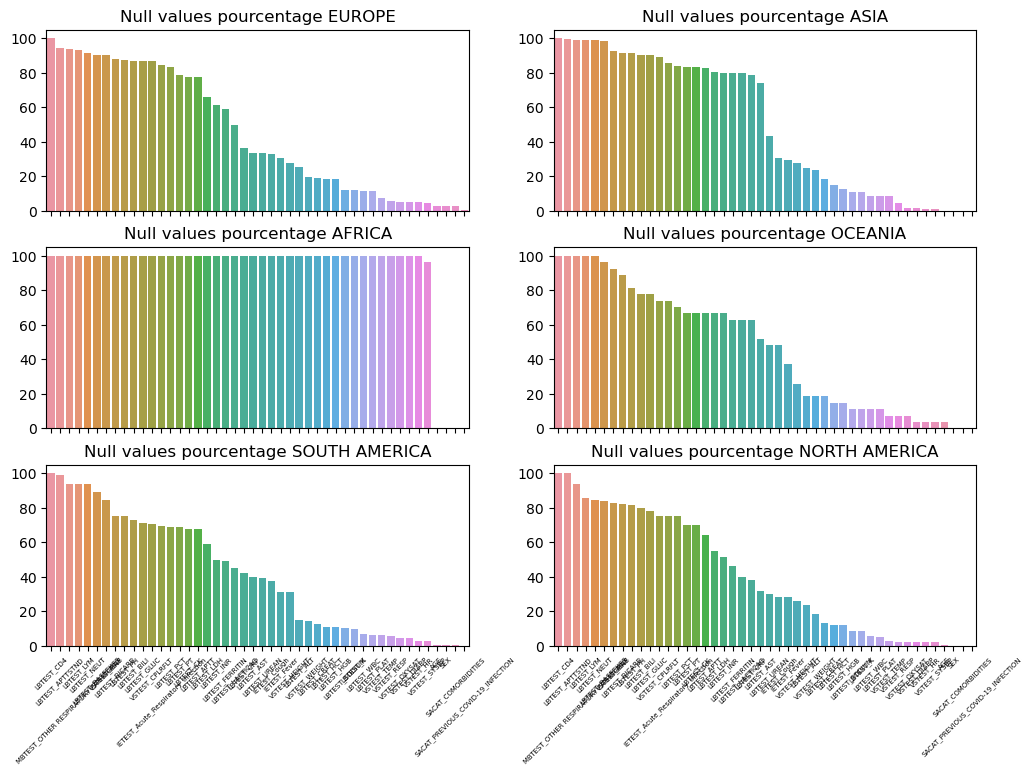

In [13]:
# Plot the repartition of the missing data for each continent

fig, axs = plt.subplots(3, 2, figsize=(12, 8), sharex=True)

null_values = df_europe.isnull().mean().sort_values(ascending=False)*100
null_values = null_values[null_values>0]
sns.barplot(x=null_values.index, y=null_values.values, ax=axs[0,0]).set_title('Null values pourcentage EUROPE')

null_values = df_asia.isnull().mean().sort_values(ascending=False)*100
null_values = null_values[null_values>0]
sns.barplot(x=null_values.index, y=null_values.values, ax=axs[0,1]).set_title('Null values pourcentage ASIA')

null_values = df_africa.isnull().mean().sort_values(ascending=False)*100
null_values = null_values[null_values>0]
sns.barplot(x=null_values.index, y=null_values.values, ax = axs[1,0]).set_title('Null values pourcentage AFRICA')

null_values = df_oceania.isnull().mean().sort_values(ascending=False)*100
null_values = null_values[null_values>0]
sns.barplot(x=null_values.index, y=null_values.values, ax=axs[1,1]).set_title('Null values pourcentage OCEANIA')

null_values = df_south_america.isnull().mean().sort_values(ascending=False)*100
null_values = null_values[null_values>0]
sns.barplot(x=null_values.index, y=null_values.values, ax=axs[2,0]).set_title('Null values pourcentage SOUTH AMERICA')

null_values = df_north_america.isnull().mean().sort_values(ascending=False)*100
null_values = null_values[null_values>0]
sns.barplot(x=null_values.index, y=null_values.values, ax=axs[2,1]).set_title('Null values pourcentage NORTH AMERICA')

for ax in axs.flatten():
    plt.sca(ax)
    plt.xticks(rotation=45, fontsize=5)

We can look at the repartition of NAs for all variables for all 6 continents :

In [14]:
dfs = [df_africa, df_asia, df_europe, df_south_america, df_north_america, df_oceania]
continents = ["Africa", "Asia", "Europe", "South America", "North America", "Oceania"]
columns = df_europe.columns
NAs = pd.DataFrame()
for i in range(len(dfs)) :
    curr_df = dfs[i]
    arr = np.zeros(len(columns))
    for j in range(len(columns)) :
        curr_col = curr_df[columns[j]]
        arr[j] = round(len(curr_col.dropna()) / len(curr_col) * 100,2)
    NAs = NAs.append(pd.Series(data = arr), ignore_index = True)
NAs.set_axis(columns, axis=1,inplace=True)
NAs.set_axis(continents, axis=0,inplace=True)
print("Number of non-NA values per continent per feature :")
NAs.T

Number of non-NA values per continent per feature :


C:\Users\felic\AppData\Local\Temp\ipykernel_11136\835951672.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  NAs = NAs.append(pd.Series(data = arr), ignore_index = True)
C:\Users\felic\AppData\Local\Temp\ipykernel_11136\835951672.py:12: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  NAs.set_axis(columns, axis=1,inplace=True)
C:\Users\felic\AppData\Local\Temp\ipykernel_11136\835951672.py:13: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  NAs.set_axis(continents, axis=0,inplace=True)


,Africa,Asia,Europe,South America,North America,Oceania
AGE,99.69,99.97,97.16,99.93,99.73,100.00
SEX,99.94,99.97,99.74,99.97,99.92,37.04
DSDECOD,100.00,100.00,100.00,100.00,100.00,100.00
HODECOD,100.00,100.00,99.99,100.00,100.00,100.00
IETEST_Acute_Respiratory_Infection,0.07,0.72,80.82,6.44,24.78,0.00
IETEST_Cough,0.07,0.72,81.23,6.38,71.63,0.00
IETEST_Fever,0.07,0.72,81.27,6.41,71.72,0.00
INCLAS_VACCINES,99.98,100.00,99.67,99.29,100.00,100.00
SACAT_COMORBIDITIES,100.00,100.00,97.34,99.39,99.96,100.00
SACAT_PREVIOUS_COVID-19_INFECTION,100.00,100.00,97.34,99.39,99.96,100.00


By taking into account the number of value and the repartition of the missing data, **we will compute our model on the European dataset**.  

Also, we can see that the Africa dataset has a very big amount of missing values, so it will discarded. The Oceania dataset is also very small (27 values), so it will also be discarded. 

In [15]:
# Keep only certain dataframes
dfs = [df_asia, df_europe, df_south_america, df_north_america]
dfs_others = [df_asia, df_south_america, df_north_america]

# Keep only some of the continents
continents = ["Asia", "Europe", "SouthAmerica", "NorthAmerica"]
continents_others = ["Asia", "SouthAmerica", "NorthAmerica"] 

In [16]:
# Check if the dataset is balanced or not
df_europe['DSDECOD'].value_counts(dropna = False)

0.0    56405
1.0    23647
Name: DSDECOD, dtype: int64

In [17]:
# Features with more then 99% of NA for Europe
list(NAs.T[NAs.T.Europe<1].index)

['LBTEST_CD4']

In [18]:
# Keep only Europe for model building + remove features with more then 99% of NA for Europe
df = df_europe
for dfi in dfs:
    dfi.drop(list(NAs.T[NAs.T.Europe<1].index), axis=1, inplace=True)
    print(dfi.shape)

(6555, 48)
(80052, 48)
(5881, 48)
(5255, 48)


C:\Users\felic\anaconda3\envs\ada\lib\site-packages\missingno\missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


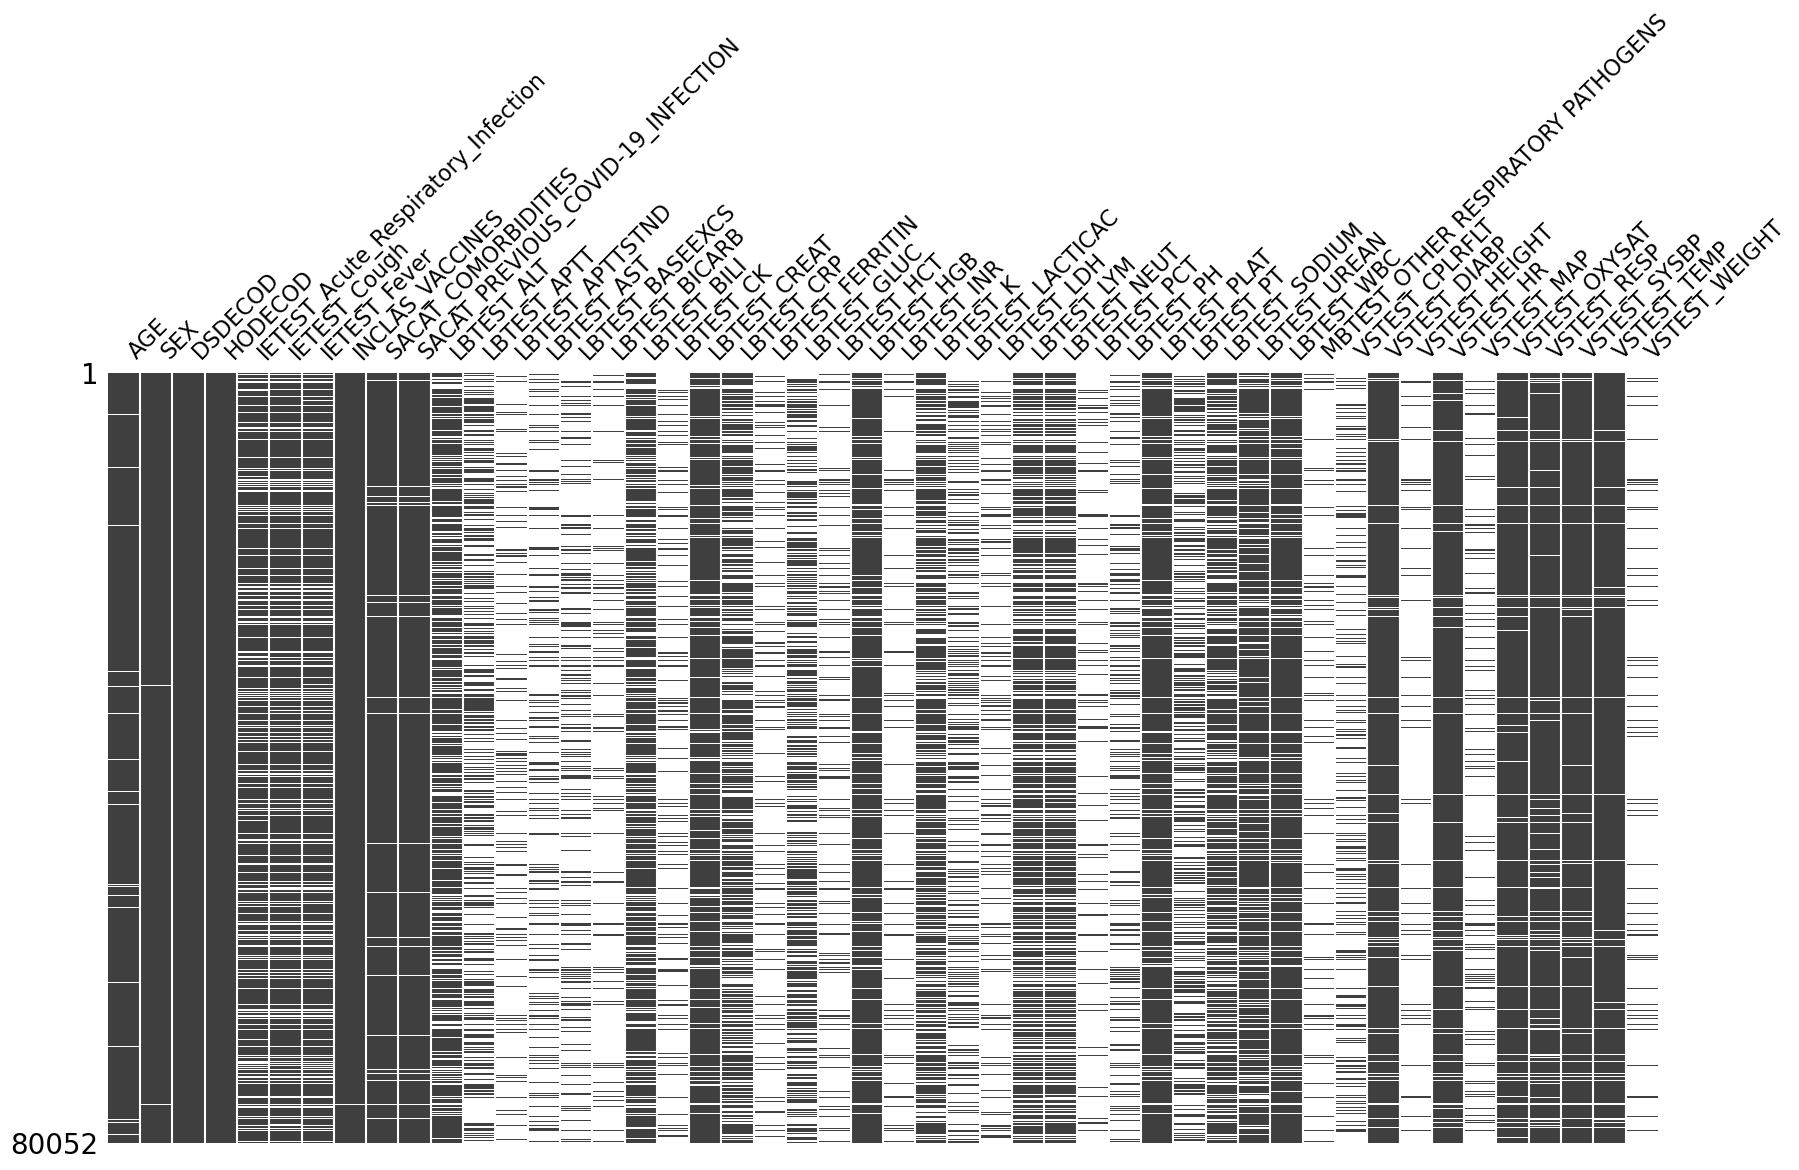

In [19]:
# Look if NA at random or not in Europe
fig, ax = plt.subplots(1, 1, figsize=(20,10))
msno.matrix(df, ax=ax, labels=True)
plt.savefig('./data/results/NA_matrix_Europe.png')

## 4 . Splitting into training and test sets

In [20]:
# Keep number of NA per columns of original dataframe 
NA_in_cols = pd.DataFrame(round(df.isna().sum()*100/len(df),1), columns=['NA_percent'])

In [21]:
df.DSDECOD.value_counts()

0.0    56405
1.0    23647
Name: DSDECOD, dtype: int64

In [22]:
# Sample to do some test before computing with all data
df = df.sample(n=200)

In [23]:
# Split into training and test sets
df_train, df_test = train_test_split(df, test_size=0.3, random_state=16)

In [24]:
print(df_train.shape)
print(df_test.shape)

(140, 48)
(60, 48)


## 5. Pre-processing of the data

During pre-processing of the data, categorical and continuous features will be treated differently.

In [25]:
# Do the list of the name of categorical columns
categorical = ['DSDECOD',
               'SEX',
               'CONTINENT_AF', 'CONTINENT_AS', 'CONTINENT_EU', 'CONTINENT_NA', 'CONTINENT_OC', 'CONTINENT_SA',
               'HODECOD', 
               'IETEST_Acute_Respiratory_Infection', 'IETEST_Cough', 'IETEST_Covid_ICU', 'IETEST_Covid_admission', 'IETEST_Dyspnoea_Tachypnoea', 'IETEST_Fever', 
               'IETEST_Inflammatory_MultiSystem_Syndrome', 'IETEST_noCovid_ICU',               
               'INCLAS_AGENTS_ACTING_ON_THE_RENIN-ANGIOTENSIN_SYSTEM', 'INCLAS_ANALGESICS', 'INCLAS_ANESTHETICS', 
               'INCLAS_ANTIBACTERIALS_FOR_SYSTEMIC_USE', 'INCLAS_ANTIHELMINTICS', 'INCLAS_ANTIINFLAMMATORY_AND_ANTIRHEUMATIC_PRODUCTS,_NON-STEROIDS',
               'INCLAS_ANTIMALARIALS', 'INCLAS_ANTIMYCOTICS_FOR_SYSTEMIC_USE', 'INCLAS_ANTITHROMBOTIC_AGENTS',
               'INCLAS_ANTIVIRALS_FOR_SYSTEMIC_USE', 'INCLAS_ARTIFICIAL_RESPIRATION', 'INCLAS_BETA_BLOCKING_AGENTS',
               'INCLAS_BLOOD_SUBSTITUTES_AND_PERFUSION_SOLUTIONS', 'INCLAS_BRONCHOSCOPY', 'INCLAS_CARDIAC_PACING',
               'INCLAS_CARDIAC_THERAPY', 'INCLAS_CARDIOPULMONARY_RESUSCITATION', 'INCLAS_CHEMOTHERAPY', 'INCLAS_CORTICOSTEROIDS_FOR_SYSTEMIC_USE',
               'INCLAS_DIURETICS', 'INCLAS_DRUGS_FOR_ACID_RELATED_DISORDERS', 'INCLAS_DRUGS_FOR_OBSTRUCTIVE_AIRWAY_DISEASES', 'INCLAS_EXTRACORPOREAL_MEMBRANE_OXYGENATION', 
               'INCLAS_HIGH_FLOW_OXYGEN_NASAL_CANNULA', 'INCLAS_IMMUNOGLOBULINS', 'INCLAS_IMMUNOSTIMULANTS', 'INCLAS_IMMUNOSUPPRESSANTS', 
               'INCLAS_INSERTION_OF_TRACHEOSTOMY_TUBE', 'INCLAS_INTUBATION', 'INCLAS_LIPID_MODIFYING_AGENTS', 'INCLAS_MUSCLE_RELAXANTS', 
               'INCLAS_NONINVASIVE_POSITIVE_PRESSURE_VENTILATION', 'INCLAS_NONINVASIVE_VENTILATION', 'INCLAS_OTHER_RESPIRATORY_SYSTEM_PRODUCTS', 
               'INCLAS_OXYGEN', 'INCLAS_PERCUTANEOUS_ENDOSCOPIC_GASTROSTOMY', 'INCLAS_PRONE_BODY_POSITION', 'INCLAS_PSYCHOLEPTICS', 
               'INCLAS_REMOVAL_OF_ENDOTRACHEAL_TUBE', 'INCLAS_RENAL_REPLACEMENT', 'INCLAS_REPLACEMENT_AGENT', 'INCLAS_TOTAL_PARENTERAL_NUTRITION', 
               'INCLAS_TRANSFUSION_OF_BLOOD_PRODUCT', 'INCLAS_VACCINES', 
               'MBTEST_ADENOVIRUS', 'MBTEST_BACTERIA','MBTEST_INFLUENZA', 'MBTEST_MB_SEVERE_ACUTE_RESP_SYND_CORONAVIRUS', 'MBTEST_OTHER PATHOGENS', 
               'MBTEST_OTHER RESPIRATORY PATHOGENS', 'MBTEST_RSV', 
               'RPSTRESC', 
               'RSCAT_AVPU', 
               'SACAT_COMORBIDITIES', 'SACAT_COMPLICATIONS', 'SACAT_PREVIOUS_COVID-19_INFECTION', 
               'SCTEST_Appropriate_Developmental_Age_Indicator', 'SCTEST_Breast_Fed_Indicator', 'SCTEST_Infant_Less_Than_One_Year_Indicator', 
               'SCTEST_Premature_Birth_Indicator']

In [26]:
# First for some columns in particular, it is more "logical" to put 0 (baseline) to fill NA

NA_to_0 = ['HODECOD', 
           'IETEST_Acute_Respiratory_Infection', 'IETEST_Cough', 'IETEST_Covid_ICU', 'IETEST_Covid_admission', 'IETEST_Dyspnoea_Tachypnoea', 'IETEST_Fever', 
           'IETEST_Inflammatory_MultiSystem_Syndrome', 'IETEST_noCovid_ICU',  
           'INCLAS_AGENTS_ACTING_ON_THE_RENIN-ANGIOTENSIN_SYSTEM', 'INCLAS_ANALGESICS', 'INCLAS_ANESTHETICS', 
           'INCLAS_ANTIBACTERIALS_FOR_SYSTEMIC_USE', 'INCLAS_ANTIHELMINTICS', 'INCLAS_ANTIINFLAMMATORY_AND_ANTIRHEUMATIC_PRODUCTS,_NON-STEROIDS',
           'INCLAS_ANTIMALARIALS', 'INCLAS_ANTIMYCOTICS_FOR_SYSTEMIC_USE', 'INCLAS_ANTITHROMBOTIC_AGENTS',
           'INCLAS_ANTIVIRALS_FOR_SYSTEMIC_USE', 'INCLAS_ARTIFICIAL_RESPIRATION', 'INCLAS_BETA_BLOCKING_AGENTS',
           'INCLAS_BLOOD_SUBSTITUTES_AND_PERFUSION_SOLUTIONS', 'INCLAS_BRONCHOSCOPY', 'INCLAS_CARDIAC_PACING',
           'INCLAS_CARDIAC_THERAPY', 'INCLAS_CARDIOPULMONARY_RESUSCITATION', 'INCLAS_CHEMOTHERAPY', 'INCLAS_CORTICOSTEROIDS_FOR_SYSTEMIC_USE',
           'INCLAS_DIURETICS', 'INCLAS_DRUGS_FOR_ACID_RELATED_DISORDERS', 'INCLAS_DRUGS_FOR_OBSTRUCTIVE_AIRWAY_DISEASES', 'INCLAS_EXTRACORPOREAL_MEMBRANE_OXYGENATION', 
           'INCLAS_HIGH_FLOW_OXYGEN_NASAL_CANNULA', 'INCLAS_IMMUNOGLOBULINS', 'INCLAS_IMMUNOSTIMULANTS', 'INCLAS_IMMUNOSUPPRESSANTS', 
           'INCLAS_INSERTION_OF_TRACHEOSTOMY_TUBE', 'INCLAS_INTUBATION', 'INCLAS_LIPID_MODIFYING_AGENTS', 'INCLAS_MUSCLE_RELAXANTS', 
           'INCLAS_NONINVASIVE_POSITIVE_PRESSURE_VENTILATION', 'INCLAS_NONINVASIVE_VENTILATION', 'INCLAS_OTHER_RESPIRATORY_SYSTEM_PRODUCTS', 
           'INCLAS_OXYGEN', 'INCLAS_PERCUTANEOUS_ENDOSCOPIC_GASTROSTOMY', 'INCLAS_PRONE_BODY_POSITION', 'INCLAS_PSYCHOLEPTICS', 
           'INCLAS_REMOVAL_OF_ENDOTRACHEAL_TUBE', 'INCLAS_RENAL_REPLACEMENT', 'INCLAS_REPLACEMENT_AGENT', 'INCLAS_TOTAL_PARENTERAL_NUTRITION', 
           'INCLAS_TRANSFUSION_OF_BLOOD_PRODUCT', 'INCLAS_VACCINES', 
           'MBTEST_ADENOVIRUS', 'MBTEST_BACTERIA','MBTEST_INFLUENZA', 'MBTEST_MB_SEVERE_ACUTE_RESP_SYND_CORONAVIRUS', 'MBTEST_OTHER PATHOGENS', 
           'MBTEST_OTHER RESPIRATORY PATHOGENS', 'MBTEST_RSV', 
           'RPSTRESC', 
           'RSCAT_AVPU', 
           'SACAT_COMORBIDITIES', 'SACAT_COMPLICATIONS']

dfs = [df_train, df_test, df_asia, df_south_america, df_north_america]
# Replace NA by 0 in NA_to_0 columns
for dfi in dfs:
    dfi[dfi.columns[dfi.columns.isin(NA_to_0)]] = dfi[dfi.columns[dfi.columns.isin(NA_to_0)]].fillna(0)

In [27]:
# Pre-process the data for Europe (Reminder: We will use Europe data for our model)

# 1. Separate in categorical and continuous columns

df_train_cat = df_train[df_train.columns[df_train.columns.isin(categorical)]]
df_train_con = df_train[df_train.columns[~df_train.columns.isin(categorical)]]
df_test_cat = df_test[df_test.columns[df_test.columns.isin(categorical)]]
df_test_con = df_test[df_test.columns[~df_test.columns.isin(categorical)]]

cols_cat = df_train_cat.columns
cols_con = df_train_con.columns

# 2. Fill the missing values 

    # For categorical variables
imp_cat = SimpleImputer(strategy="most_frequent")
imp_cat = imp_cat.fit(df_train_cat)

df_train_cat = imp_cat.transform(df_train_cat)
df_test_cat = imp_cat.transform(df_test_cat)
df_train_cat = pd.DataFrame(df_train_cat, columns=cols_cat)
df_test_cat = pd.DataFrame(df_test_cat, columns=cols_cat)

    # For continuous variables
imp_con = SimpleImputer(strategy="median")
imp_con = imp_con.fit(df_train_con)

df_train_con = imp_con.transform(df_train_con)
df_test_con = imp_con.transform(df_test_con)
df_train_con = pd.DataFrame(df_train_con, columns=cols_con)
df_test_con = pd.DataFrame(df_test_con, columns=cols_con)

# 3. Standardization of continuous data

scaler_europe = StandardScaler()
scaler_europe = scaler_europe.fit(df_train_con)

df_train_con = scaler_europe.transform(df_train_con)
df_test_con = scaler_europe.transform(df_test_con)
df_train_con = pd.DataFrame(df_train_con, columns=cols_con)
df_test_con = pd.DataFrame(df_test_con, columns=cols_con)

# 4. Creation of X and y matrixes

df_train = pd.concat([df_train_cat, df_train_con], axis=1)
df_test = pd.concat([df_test_cat, df_test_con], axis=1)

X_train = df_train.loc[:, df_train.columns!='DSDECOD']
y_train = df_train['DSDECOD']
X_test = df_test.loc[:, df_test.columns!='DSDECOD']
y_test = df_test['DSDECOD']

# 5. Get feature names

features = df_train.loc[:, df_train.columns!='DSDECOD'].columns

# 6. Oversampling of train set

ada = ADASYN(random_state=42)
X_train, y_train = ada.fit_resample(X_train, y_train)

C:\Users\felic\anaconda3\envs\ada\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


In [28]:
y_train.value_counts()

1.0    98
0.0    96
Name: DSDECOD, dtype: int64

In [29]:
# Pre-process the other continents


# We want to standardize the other continents' datasets according either to their own mean and standard 
# deviation or those of the europe dataset

def standardizeOthers(df_other, scaler_europe, cols_con): 
    
    # Standardize according to own mean and standard deviation
    scaler_specific = StandardScaler().fit(df_other)
    df_other_self = scaler_specific.transform(df_other)
    df_other_self = pd.DataFrame(df_other_self, columns=cols_con)
    
    # Standardize according to mean and standard deviation of europe training dataset
    df_other_nonself = scaler_europe.transform(df_other)
    df_other_nonself = pd.DataFrame(df_other_nonself, columns=cols_con)
    
    return df_other_self, df_other_nonself


# This will contain the datasets of other continents standardized according to their own mean and standard deviation
dfs_others_SelfStd = []
# This will contain the datasets of other continents standardized according to the mean and standard deviation of the europe dataset 
dfs_others_NonSelfStd = []
# Reminder : order in these lists : continents_others = ["Asia", "SouthAmerica", "NorthAmerica"] 


# Do pre-processing for other continents

for dfi in dfs_others:
    
    # 1. Separate in continuous and categorical values
    
    dfi_cat = dfi[dfi.columns[dfi.columns.isin(categorical)]]
    dfi_con = dfi[dfi.columns[~dfi.columns.isin(categorical)]]
    
    cols_cat = dfi_cat.columns
    cols_con = dfi_con.columns
    
    # 2. Fill the missing values 

        # For categorical variables 
    imp_cat = SimpleImputer(strategy="most_frequent").fit(dfi_cat)
    dfi_cat = imp_cat.transform(dfi_cat)
    dfi_cat = pd.DataFrame(dfi_cat, columns=cols_cat)

        # For continuous variables
    imp_con = SimpleImputer(strategy="median").fit(dfi_con)
    dfi_con = imp_con.transform(dfi_con)
    dfi_con = pd.DataFrame(dfi_con, columns=cols_con)
    
    # 3. Standardization of continuous data
    
    dfi_con_self, dfi_con_nonself = standardizeOthers(dfi_con, scaler_europe, cols_con)
    
    # 4. Concat con and cat and save dataframe
    
    dfi_self = pd.concat([dfi_cat, dfi_con_self], axis=1)
    dfs_others_SelfStd.append(dfi_self)
    
    dfi_nonself = pd.concat([dfi_cat, dfi_con_nonself], axis=1)
    dfs_others_NonSelfStd.append(dfi_nonself)    

C:\Users\felic\anaconda3\envs\ada\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
C:\Users\felic\anaconda3\envs\ada\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid thi

## 6. Feature selection algorithms

Les propositions sont faites à partir de: https://scikit-learn.org/stable/modules/feature_selection.html

In [30]:
# /!\ CHOOSE THE CLASSIFIER /!\
classifier = LogisticRegression()
name_classifier = 'LogisticRegression' # give the name of the classifier (str) to save the file at the end

# /!\ CHOOSE THE MINIMUM NUMBER OF FEATURES TO CONSIDER /!\
min_features_to_select = 15 

# List of possible classifiers :
# These are the classifiers we will test in the file "III_models-and-presdictions"
    # LogisticRegression()
    # KNeighborsClassifier()
    # svm.SVC()
    # MLPClassifier()
    # QuadraticDiscriminantAnalysis()
    # xgb.XGBClassifier(objective="binary:logistic", random_state=42)

### 6.1. Recursive feature elimination (RFE) with cross-validation

In [31]:
%%time
# Create the RFE object and compute a cross-validated score
classifier = LogisticRegression(max_iter = 500)

rfecv = RFECV(estimator=classifier,
              step=1,
              cv=StratifiedKFold(4),
              scoring='f1',
              min_features_to_select=min_features_to_select)
rfecv.fit(X_train, y_train)

CPU times: total: 891 ms
Wall time: 909 ms


RFECV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
      estimator=LogisticRegression(max_iter=500), min_features_to_select=15,
      scoring='f1')

Optimal number of features : 41


C:\Users\felic\anaconda3\envs\ada\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


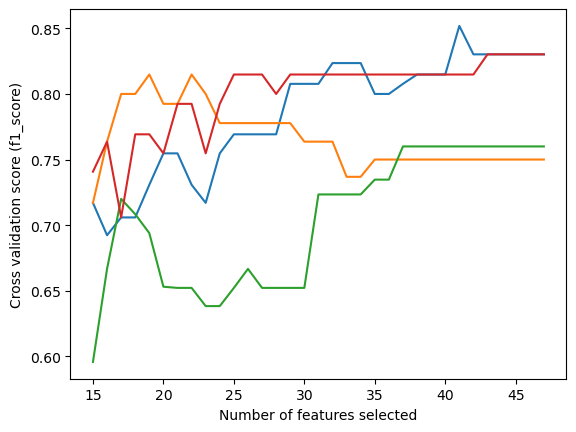

In [32]:
# Optimal number of features
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (f1_score)")
plt.plot(range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

In [33]:
# See feature ranking
df_rfecv = pd.DataFrame(list(zip(features, rfecv.ranking_)), columns =['Feature', 'Rank']).sort_values(by='Rank')
df_rfecv.head(40)

,Feature,Rank
0,SEX,1
24,LBTEST_INR,1
25,LBTEST_K,1
26,LBTEST_LACTICAC,1
27,LBTEST_LDH,1
28,LBTEST_LYM,1
29,LBTEST_NEUT,1
30,LBTEST_PCT,1
32,LBTEST_PLAT,1
45,VSTEST_TEMP,1


In [34]:
# Colonnes selected
features_rfecv = features[rfecv.support_]
features_rfecv

Index(['SEX', 'HODECOD', 'IETEST_Acute_Respiratory_Infection', 'IETEST_Cough',
       'IETEST_Fever', 'INCLAS_VACCINES', 'SACAT_COMORBIDITIES',
       'MBTEST_OTHER RESPIRATORY PATHOGENS', 'AGE', 'LBTEST_APTT',
       'LBTEST_APTTSTND', 'LBTEST_AST', 'LBTEST_BICARB', 'LBTEST_BILI',
       'LBTEST_CK', 'LBTEST_CREAT', 'LBTEST_CRP', 'LBTEST_FERRITIN',
       'LBTEST_GLUC', 'LBTEST_HCT', 'LBTEST_HGB', 'LBTEST_INR', 'LBTEST_K',
       'LBTEST_LACTICAC', 'LBTEST_LDH', 'LBTEST_LYM', 'LBTEST_NEUT',
       'LBTEST_PCT', 'LBTEST_PLAT', 'LBTEST_PT', 'LBTEST_SODIUM',
       'LBTEST_UREAN', 'LBTEST_WBC', 'VSTEST_DIABP', 'VSTEST_HEIGHT',
       'VSTEST_HR', 'VSTEST_MAP', 'VSTEST_OXYSAT', 'VSTEST_RESP',
       'VSTEST_TEMP', 'VSTEST_WEIGHT'],
      dtype='object')

### 6.2. Sequential Feature Selection

We will test two approaches for feature selection: SelectFromModel which is based on feature importance, and SequentialFeatureSelection which relies on a greedy approach.

*NB from Sklearn:*
- In general, the two methods would lead to different results.
- We also note that the features selected by SFS differ from those selected by feature importance.
- To finish with, we should note that SelectFromModel is significantly faster than SFS. Indeed, SelectFromModel only needs to fit a model once, while SFS needs to cross-validate many different models for each of the iterations. SFS however works with any model, while SelectFromModel requires the underlying estimator to expose a coef_ attribute or a feature_importances_ attribute. The forward SFS is faster than the backward SFS because it only needs to perform n_features_to_select = 2 iterations, while the backward SFS needs to perform n_features - n_features_to_select = 8 iterations.

#### 6.2.1. SelectFromModel

Before using selectFromModel, we will get an idea of the importance of the features. The features with the highest absolute coef_ value are considered the most important.

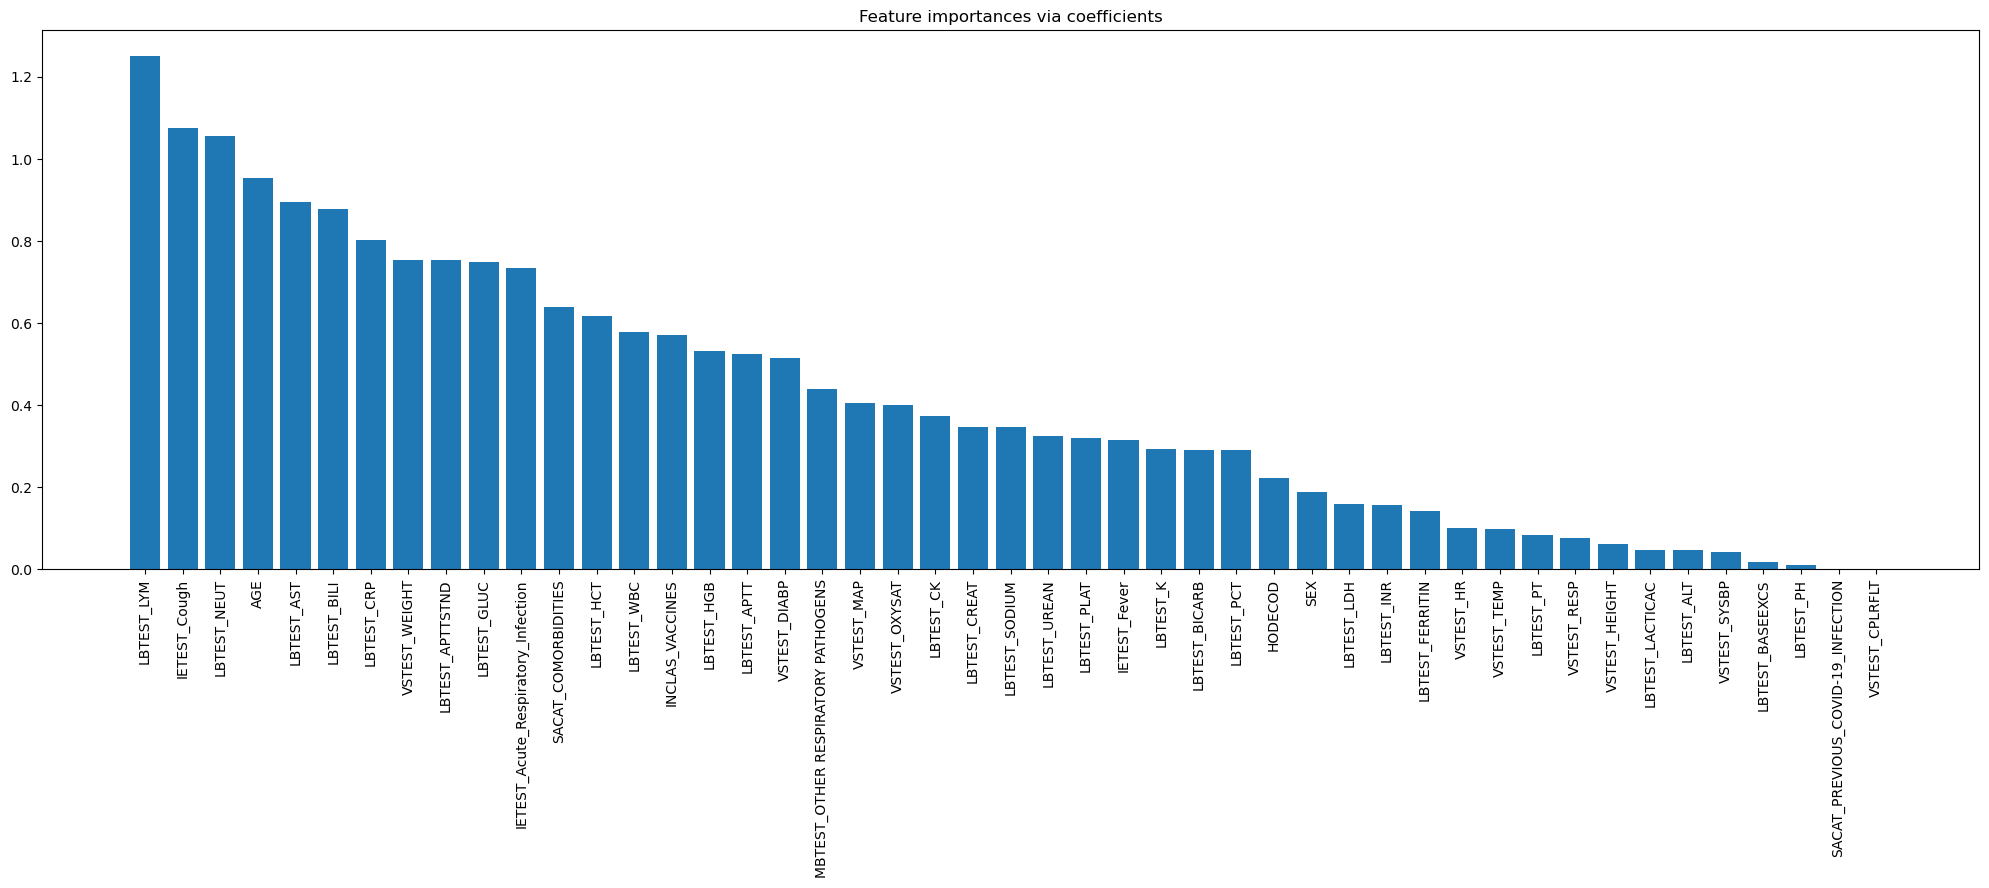

CPU times: total: 328 ms
Wall time: 365 ms


In [35]:
%%time
# Feature importance from coefficients
classifier = LogisticRegression(max_iter = 500)
importance_fit = classifier.fit(X_train, y_train)

if len(importance_fit.coef_.tolist())>1:
       importance = np.abs(importance_fit.coef_)  
else:
       importance = np.abs(importance_fit.coef_.tolist()[0])

df_importance = pd.DataFrame(list(zip(features, importance)), columns =['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(25, 7))
plt.bar('Feature', 'Importance', data=df_importance)
plt.title("Feature importances via coefficients")
plt.xticks(rotation=90)
plt.show()

In [36]:
# See feature ranking
df_importance.head(10)

,Feature,Importance
28,LBTEST_LYM,1.251043
3,IETEST_Cough,1.074388
29,LBTEST_NEUT,1.054519
9,AGE,0.952100
13,LBTEST_AST,0.893673
16,LBTEST_BILI,0.876655
19,LBTEST_CRP,0.801629
46,VSTEST_WEIGHT,0.753486
12,LBTEST_APTTSTND,0.752629
21,LBTEST_GLUC,0.748784


Now we select features which are the most important according to the coefficients using SelectFromModel.

In [37]:
%%time
# SelectFromModel

threshold = np.sort(importance)[-35] + 0.01
sfm = SelectFromModel(classifier, threshold=threshold).fit(X_train, y_train)

features_sfm = features[sfm.get_support()]
print(f"Features selected by SelectFromModel: {features_sfm}")

Features selected by SelectFromModel: Index(['SEX', 'HODECOD', 'IETEST_Acute_Respiratory_Infection', 'IETEST_Cough',
       'IETEST_Fever', 'INCLAS_VACCINES', 'SACAT_COMORBIDITIES',
       'MBTEST_OTHER RESPIRATORY PATHOGENS', 'AGE', 'LBTEST_APTT',
       'LBTEST_APTTSTND', 'LBTEST_AST', 'LBTEST_BICARB', 'LBTEST_BILI',
       'LBTEST_CK', 'LBTEST_CREAT', 'LBTEST_CRP', 'LBTEST_GLUC', 'LBTEST_HCT',
       'LBTEST_HGB', 'LBTEST_INR', 'LBTEST_K', 'LBTEST_LDH', 'LBTEST_LYM',
       'LBTEST_NEUT', 'LBTEST_PCT', 'LBTEST_PLAT', 'LBTEST_SODIUM',
       'LBTEST_UREAN', 'LBTEST_WBC', 'VSTEST_DIABP', 'VSTEST_MAP',
       'VSTEST_OXYSAT', 'VSTEST_WEIGHT'],
      dtype='object')
CPU times: total: 15.6 ms
Wall time: 8 ms


In [38]:
len(features_sfm)

34

#### 6.2.2 SequentialFeatureSelection

In [39]:
%%time
# SequentialFeatureSelection
classifier = LogisticRegression(max_iter = 500)
sfs_forward = SequentialFeatureSelector(classifier, n_features_to_select=20, direction="forward").fit(X_train, y_train)

CPU times: total: 13.8 s
Wall time: 14.1 s


In [40]:
%%time
# sfs_backward is veeeery long
classifier = LogisticRegression(max_iter = 500)
sfs_backward = SequentialFeatureSelector(classifier, n_features_to_select=20, direction="backward").fit(X_train, y_train)

CPU times: total: 27.6 s
Wall time: 28.2 s


In [41]:
# Features selected

features_sfs_forward = features[sfs_forward.get_support()]
print("Features selected by forward sequential selection:\n " f"{features_sfs_forward}")

#print('------')

features_sfs_backward = features[sfs_backward.get_support()]
print("Features selected by backward sequential selection:\n " f"{features_sfs_backward}")

Features selected by forward sequential selection:
 Index(['HODECOD', 'INCLAS_VACCINES', 'SACAT_COMORBIDITIES',
       'SACAT_PREVIOUS_COVID-19_INFECTION',
       'MBTEST_OTHER RESPIRATORY PATHOGENS', 'LBTEST_ALT', 'LBTEST_APTTSTND',
       'LBTEST_AST', 'LBTEST_BICARB', 'LBTEST_CK', 'LBTEST_CRP', 'LBTEST_INR',
       'LBTEST_LDH', 'LBTEST_LYM', 'LBTEST_PH', 'LBTEST_PT', 'LBTEST_UREAN',
       'VSTEST_CPLRFLT', 'VSTEST_DIABP', 'VSTEST_WEIGHT'],
      dtype='object')
Features selected by backward sequential selection:
 Index(['SEX', 'IETEST_Acute_Respiratory_Infection', 'IETEST_Cough',
       'LBTEST_APTT', 'LBTEST_AST', 'LBTEST_BASEEXCS', 'LBTEST_BILI',
       'LBTEST_CK', 'LBTEST_CRP', 'LBTEST_GLUC', 'LBTEST_HCT', 'LBTEST_INR',
       'LBTEST_LYM', 'LBTEST_PLAT', 'LBTEST_PT', 'LBTEST_SODIUM',
       'LBTEST_UREAN', 'VSTEST_DIABP', 'VSTEST_OXYSAT', 'VSTEST_TEMP'],
      dtype='object')


## 7. Conclusions and final features selection

In [42]:
# Convert list of features selected in pd.Series
features_rfecv = pd.Series(features_rfecv)
features_sfm = pd.Series(features_sfm)
features_sfs_forward = pd.Series(features_sfs_forward)
features_sfs_backward = pd.Series(features_sfs_backward)

# List of all unique features selected for all methods
features_all = pd.Series(pd.concat([features_rfecv, features_sfm, features_sfs_forward]).unique())  # features_sfs_backward

# Test for each method if the given feature is selected for each feature in features_all
test_rfecv = features_all.isin(features_rfecv)
test_sfm = features_all.isin(features_sfm)
test_sfs_forward = features_all.isin(features_sfs_forward)
test_sfs_backward = features_all.isin(features_sfs_backward)

# Construct dataframe
df_comparison = pd.DataFrame(list(zip(features_all, test_rfecv, test_sfm, test_sfs_forward, test_sfs_backward)), # test_sfs_backward
                             columns =['Feature', 'rfecv', 'sfm', 'sfs_fwd', 'sfs_bkd']) # 'sfs_bkd'

# Add column with number of True
df_comparison['Number'] = df_comparison.sum(axis=1)

# Sort values
df_comparison = df_comparison.sort_values(by='Number', ascending=False) \
                             .replace({False:"", True:"X"})

# Add number of NA for each column for the whole original dataframe
df_comparison['NA_percent'] = NA_in_cols.loc[df_comparison.set_index('Feature').index, 'NA_percent'].tolist()


# Display comparison
df_comparison.set_index('Feature')

C:\Users\felic\AppData\Local\Temp\ipykernel_11136\3274518152.py:21: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_comparison['Number'] = df_comparison.sum(axis=1)


,rfecv,sfm,sfs_fwd,sfs_bkd,Number,NA_percent
Feature,,,,,,
LBTEST_CK,X,X,X,X,4,86.6
LBTEST_UREAN,X,X,X,X,4,19.5
LBTEST_LYM,X,X,X,X,4,33.2
LBTEST_INR,X,X,X,X,4,93.3
VSTEST_DIABP,X,X,X,X,4,5.3
LBTEST_AST,X,X,X,X,4,83.2
LBTEST_CRP,X,X,X,X,4,36.5
LBTEST_PT,X,,X,X,3,58.8
LBTEST_SODIUM,X,X,,X,3,30.7


**Discussion**: **=> !!!TODO!!!**  
Discuter des features à garder en fonction du tableau au dessus, des NA, de la littérature, etc...  
Commenter/argumenter/critiquer...

In [43]:
# Choose columns we want to keep to then test models

features_toKeep = features_sfs_backward

X_selection_train = X_train[features_toKeep]
X_selection_test = X_test[features_toKeep]
df_selection_train = pd.concat([X_selection_train, y_train], axis=1)
df_selection_test = pd.concat([X_selection_test, y_test], axis=1)

df_selection_train.head(3)

,SEX,IETEST_Acute_Respiratory_Infection,IETEST_Cough,LBTEST_APTT,LBTEST_AST,LBTEST_BASEEXCS,LBTEST_BILI,LBTEST_CK,LBTEST_CRP,LBTEST_GLUC,...,LBTEST_INR,LBTEST_LYM,LBTEST_PLAT,LBTEST_PT,LBTEST_SODIUM,LBTEST_UREAN,VSTEST_DIABP,VSTEST_OXYSAT,VSTEST_TEMP,DSDECOD
0,1.0,1.0,0.0,-2.557180,-0.925641,0.118033,-0.406968,-0.096034,-0.853988,-0.182672,...,-0.071396,0.779200,1.044743,-0.911537,1.845054,-0.360674,1.673147,-1.785549,1.885663,0.0
1,1.0,0.0,1.0,1.247627,-0.114622,0.118033,-0.066046,-0.096034,-0.799940,0.525929,...,-0.071396,-0.200002,0.174429,-0.113087,0.983311,0.321250,0.844893,-0.384212,0.880742,0.0
2,1.0,0.0,1.0,-0.165587,-0.114622,0.118033,-0.009225,-0.096034,1.591686,-0.182672,...,-0.071396,-0.293026,-0.064481,0.685364,-0.093868,0.154248,0.741361,-2.647909,1.584186,1.0


Before the final selection of the features to keep, let's see whether some of them are correlated :

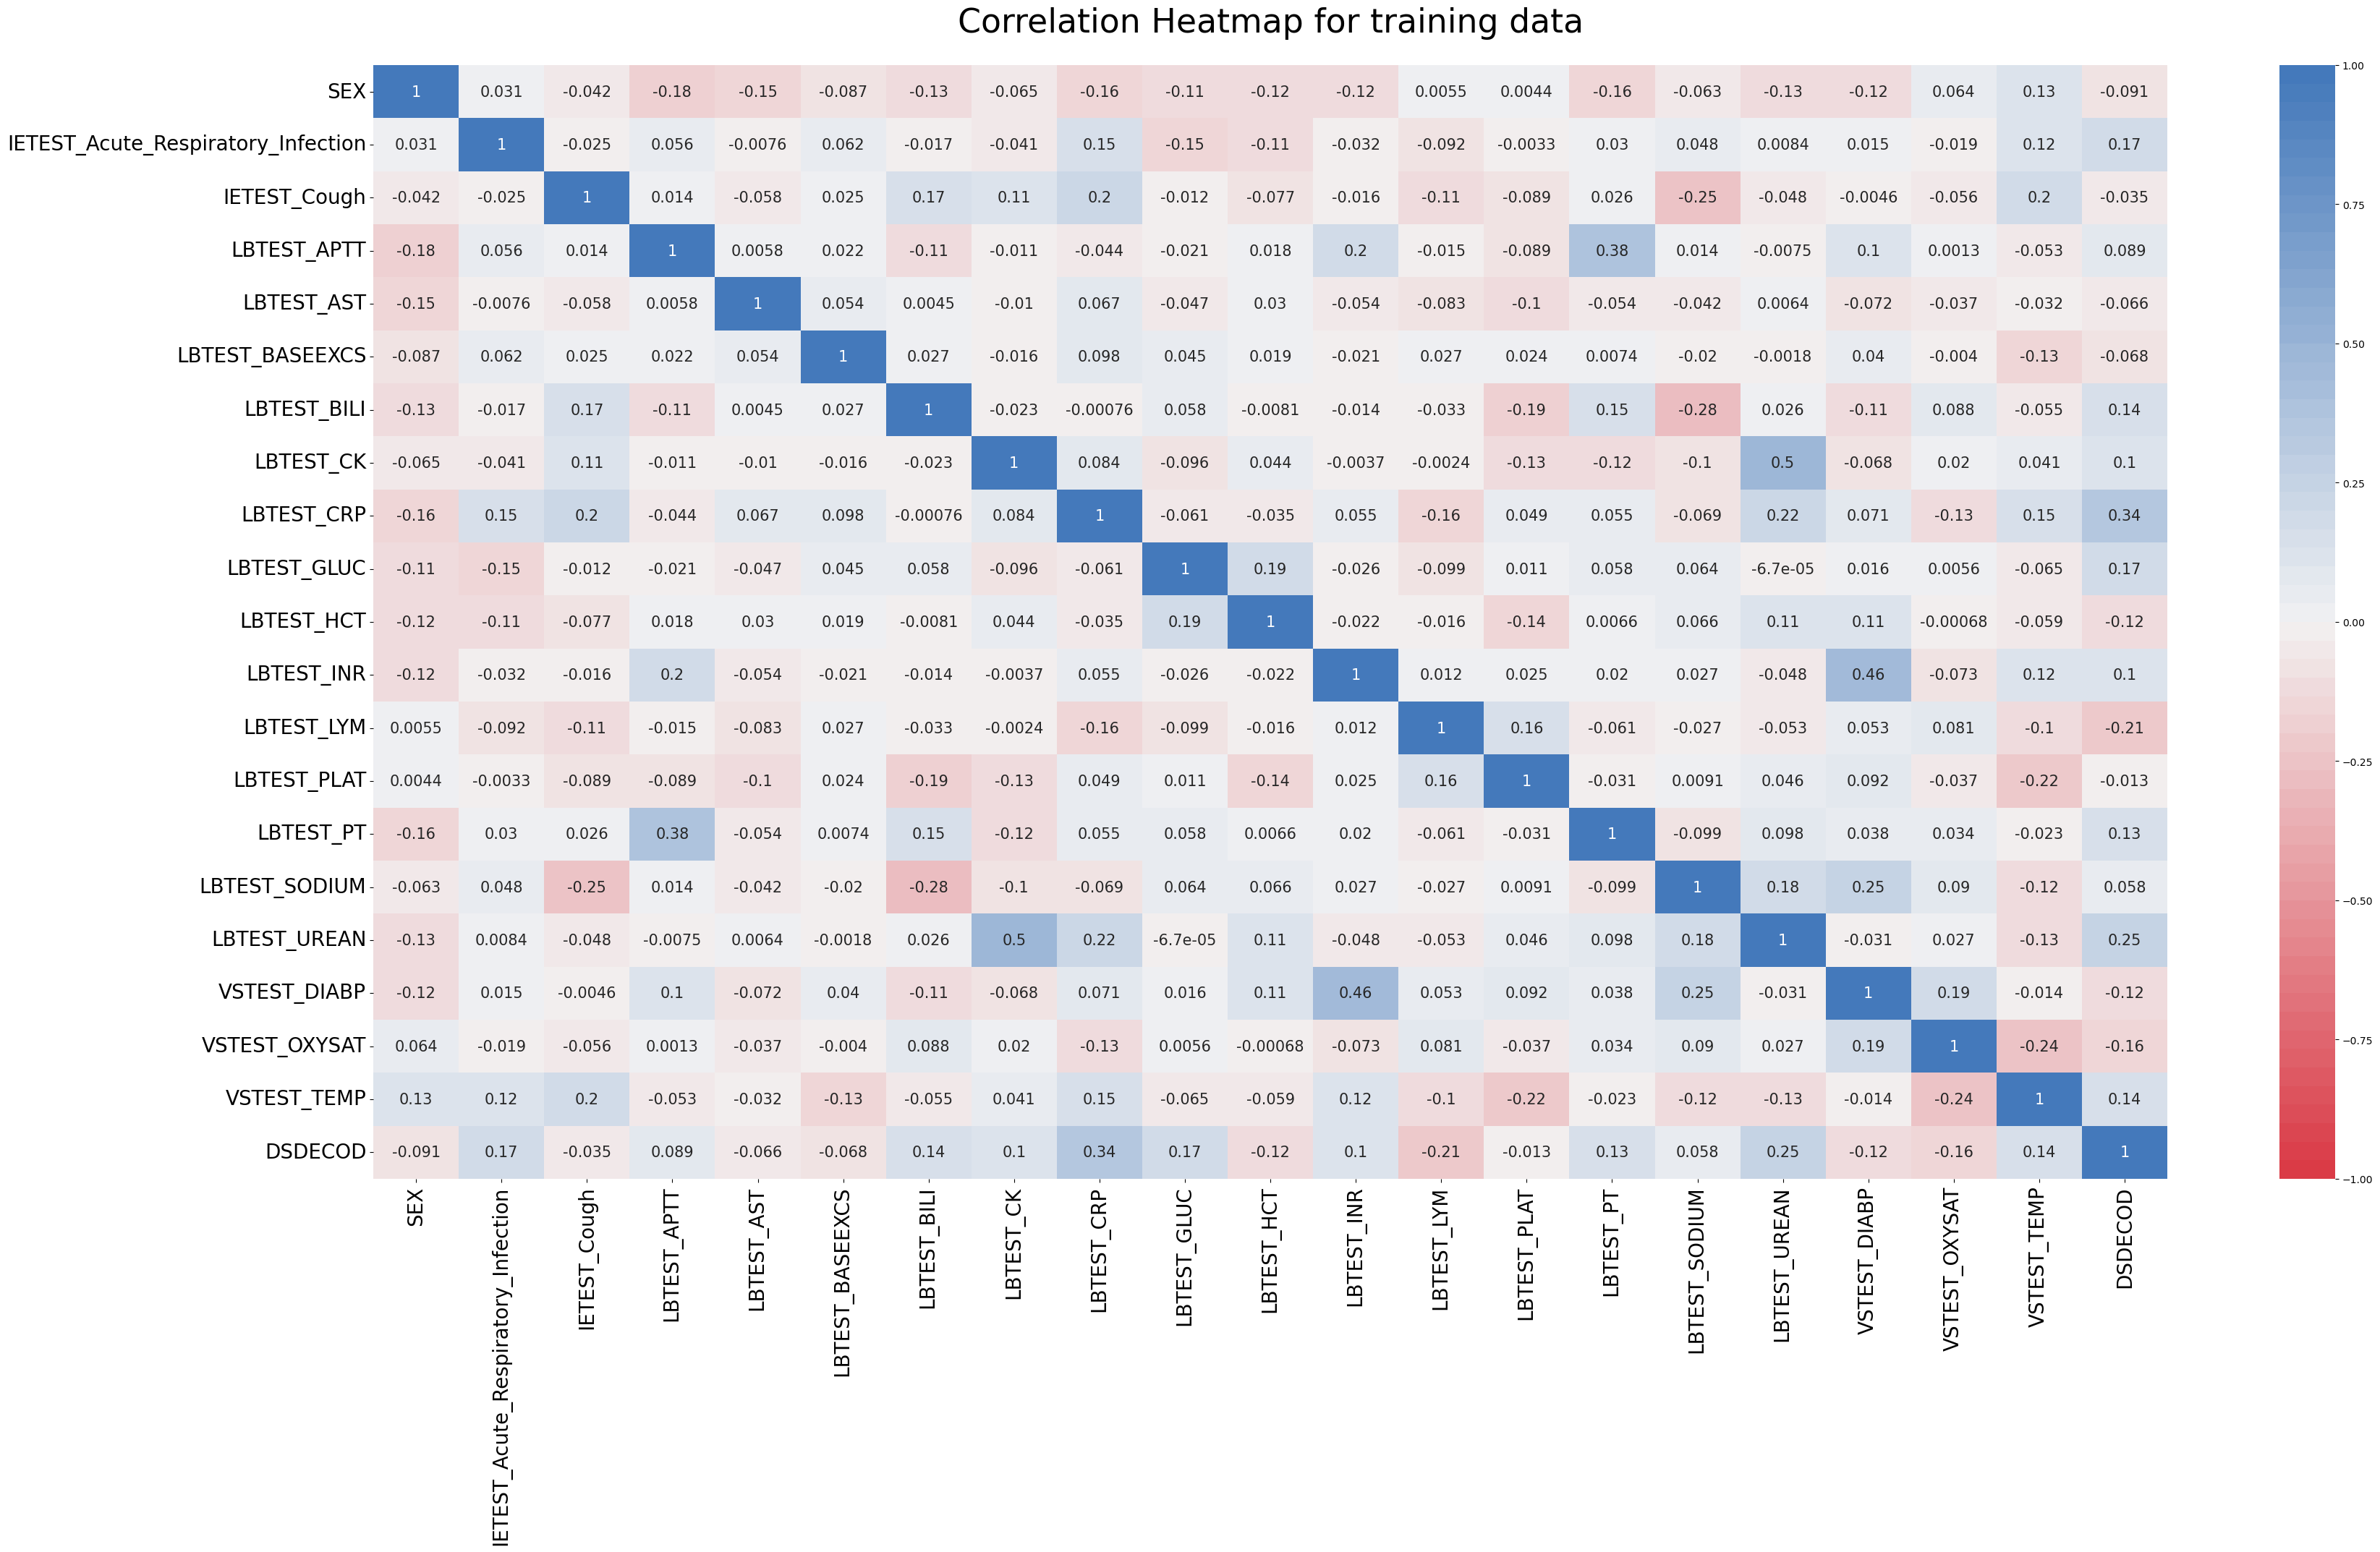

In [44]:
plt.figure(figsize=(40, 20))
heatmap = sns.heatmap(df_selection_train.corr(), vmin=-1, vmax=1, annot=True, cmap = sns.diverging_palette(10,250, n=60), annot_kws={"fontsize":15})
heatmap.set_title('Correlation Heatmap for training data', fontdict={'fontsize':33}, pad=33)
plt.tick_params(axis='both', labelsize=20)
plt.savefig('./data/results/corrHeatmap_traindata.png')

We can see that there are no particularly stron correlations (coefficient over 0.5). We can however see some moderately strong correlations between vaccines, acute respiratory infection, fever and age. Being vaccinated seems to lead to less acute respiratory infections, less fever and seems to the case for younger people.  

We can also see some moderately strong positive correlations between age and death (i.e. the older the person is, the more likely they are to die) which is pretty intuitive, as well as another positive one between height and weight which is also intuitive. 

In [45]:
# Save train and test
# Files that contains the data for only the features we want to keep. Features are already fill for NA and also standardized.

name_file_train = 'df_final_II-FeaturesSelection_train_' + name_classifier + '_alldata.csv'
name_file_test = 'df_final_II-FeaturesSelection_test_' + name_classifier + '_alldata.csv'

df_selection_train.to_csv(op.join(data_folder, name_file_train))
df_selection_test.to_csv(op.join(data_folder, name_file_test))

In [46]:
# Save other continents
# Files that contains the data for only the features we want to keep. Features are already fill for NA and also standardized.

    # dfs_others_SelfStd
for i, dfi in enumerate(dfs_others_SelfStd):
    name_file = 'df_' + continents_others[i] + '_SelfStd.csv'
    dfi[features_toKeep.append(pd.Series('DSDECOD'))].to_csv(op.join(data_folder, name_file))
        
    # dfs_others_NonSelfStd
for i, dfi in enumerate(dfs_others_NonSelfStd):
    name_file = 'df_' + continents_others[i] + '_NonSelfStd.csv'
    dfi[features_toKeep.append(pd.Series('DSDECOD'))].to_csv(op.join(data_folder, name_file))

C:\Users\felic\AppData\Local\Temp\ipykernel_11136\2807799834.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfi[features_toKeep.append(pd.Series('DSDECOD'))].to_csv(op.join(data_folder, name_file))
C:\Users\felic\AppData\Local\Temp\ipykernel_11136\2807799834.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfi[features_toKeep.append(pd.Series('DSDECOD'))].to_csv(op.join(data_folder, name_file))
C:\Users\felic\AppData\Local\Temp\ipykernel_11136\2807799834.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfi[features_toKeep.append(pd.Series('DSDECOD'))].to_csv(op.join(data_folder, name_file))
C:\Users\felic\AppData\Local\Temp\ipykernel_11136\2807799834.py:12: FutureWarning: The series.append method is deprecated